## GPU Statistics

In [2]:
!nvidia-smi

Wed Nov  9 15:17:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   32C    P8    15W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load Data

In [3]:
!pip install -r requirements.txt
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sklearn


# Import necessary modules

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

# Keras specific
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical 
import joblib

df = pd.read_csv('road_roughness_data.csv')
df.describe()

2022-11-09 15:17:06.459691: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-09 15:17:06.631822: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-09 15:17:06.669573: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-09 15:17:07.344651: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

,acc_x,acc_y,acc_z,speed,gyro_x,gyro_y,gyro_z,road_condition
count,144036.000000,144036.000000,144036.000000,144036.000000,144036.000000,144036.000000,144036.000000,144036.000000
mean,-0.171308,0.015106,9.719331,9.556871,-0.082291,-0.036224,0.081065,1.238982
std,1.399775,1.940585,1.831907,7.746386,4.391095,5.473887,4.260343,0.699646
min,-10.735600,-13.446734,-6.418376,0.002526,-51.906967,-63.358116,-23.177338,0.000000
25%,-0.912191,-0.829292,8.904515,4.508887,-1.613998,-2.231407,-1.250458,1.000000
50%,-0.102951,0.090082,9.754456,6.618945,-0.088120,-0.003624,-0.029755,1.000000
75%,0.543484,0.839467,10.522995,16.647470,1.453018,2.224159,1.190948,2.000000
max,9.033323,14.258967,24.665544,26.874480,37.692642,67.897987,29.297638,2.000000


## Features

In [4]:
df.iloc[:,:-1]

,acc_x,acc_y,acc_z,speed,gyro_x,gyro_y,gyro_z
0,0.365116,0.167893,9.793961,0.009128,-0.133896,-0.018883,0.138092
1,0.392649,0.176273,9.771216,0.009128,-0.027084,-0.003624,0.000763
2,0.409408,0.181062,9.732909,0.009128,0.125504,-0.186729,-0.090790
3,0.371101,0.164302,9.749668,0.009128,-0.088120,-0.034142,0.046539
4,0.390255,0.159514,9.869378,0.009128,-0.179672,0.118446,-0.182343
...,...,...,...,...,...,...,...
144031,-0.527921,-0.322918,9.583271,0.005715,-0.332260,-0.095177,-0.060272
144032,-0.663194,-0.575506,9.433633,0.005715,-0.240707,-0.308800,-0.182343
144033,-0.375890,-0.245106,9.957964,0.005715,0.064468,-0.156212,0.000763
144034,-0.385466,-0.091877,9.840648,0.005715,-0.423813,0.820351,-0.243378


## Target variable

In [5]:
df.iloc[:,-1:]

,road_condition
0,2
1,2
2,2
3,2
4,2
...,...
144031,2
144032,2
144033,2
144034,2


## Split data into Train and Test sets

In [6]:
from sklearn.model_selection import train_test_split

X = df.iloc[:,:-1]
y= df['road_condition']

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30) # 70% training and 30% test

## Fit tensorflow model to Train set

In [7]:
import tensorflow as tf
tf.random.set_seed(42)


model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(lr=0.03),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

history = model.fit(X_train, y_train, epochs=100)


Epoch 1/100


2022-11-09 15:17:19.923054: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 15:17:19.960859: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 15:17:19.962800: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 15:17:19.964872: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

3151/3151 [==============================] - 11s 3ms/step - loss: -1366776436752384.0000 - accuracy: 0.4526 - precision: 0.8457 - recall: 0.9997
Epoch 2/100
3151/3151 [==============================] - 9s 3ms/step - loss: -24965238289858560.0000 - accuracy: 0.4527 - precision: 0.8457 - recall: 1.0000
Epoch 3/100
3151/3151 [==============================] - 9s 3ms/step - loss: -115115955440320512.0000 - accuracy: 0.4527 - precision: 0.8457 - recall: 1.0000
Epoch 4/100
3151/3151 [==============================] - 9s 3ms/step - loss: -324194954819665920.0000 - accuracy: 0.4527 - precision: 0.8457 - recall: 1.0000
Epoch 5/100
3151/3151 [==============================] - 9s 3ms/step - loss: -718447629465288704.0000 - accuracy: 0.4527 - precision: 0.8457 - recall: 1.0000
Epoch 6/100
3151/3151 [==============================] - 9s 3ms/step - loss: -1369787391362990080.0000 - accuracy: 0.4527 - precision: 0.8457 - recall: 1.0000
Epoch 7/100
3151/3151 [==============================] - 9s 3ms/s

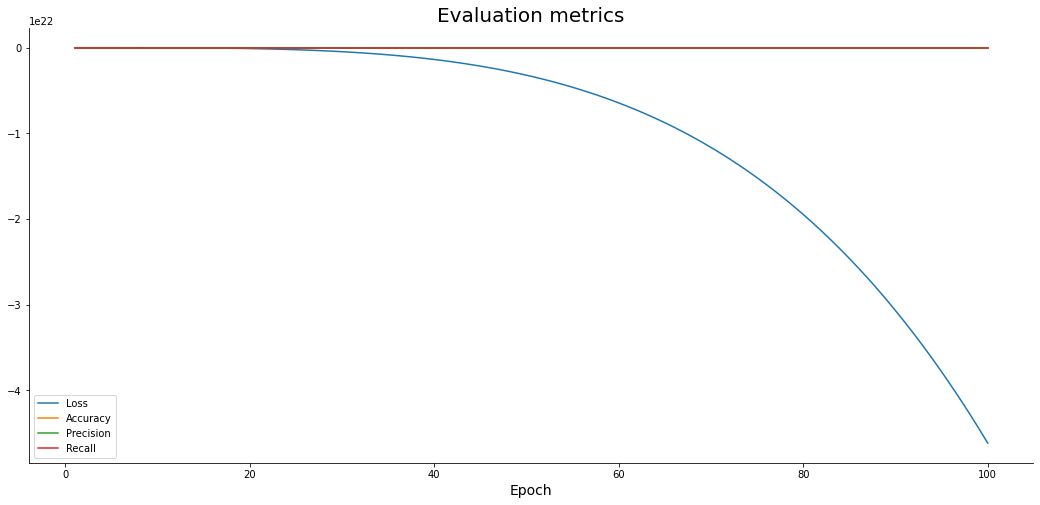

In [11]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = (18, 8)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
plt.plot(
    np.arange(1, 101), 
    history.history['loss'], label='Loss'
)
plt.plot(
    np.arange(1, 101), 
    history.history['accuracy'], label='Accuracy'
)
plt.plot(
    np.arange(1, 101), 
    history.history['precision'], label='Precision'
)
plt.plot(
    np.arange(1, 101), 
    history.history['recall'], label='Recall'
)
plt.title('Evaluation metrics', size=20)
plt.xlabel('Epoch', size=14)
plt.legend();


## Run prediciton on test data

In [9]:
predictions = model.predict(X_test)
scores2 = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy on test data: {}% \n Error on test data: {}'.format(scores2[1], 1 - scores2[1]))    

1351/1351 [==============================] - 2s 1ms/step
Accuracy on test data: 0.4549073278903961% 
 Error on test data: 0.5450926721096039


## Save the model

In [15]:
model.save('my_model')

INFO:tensorflow:Assets written to: my_model/assets


## Load model

In [14]:
new_model = tf.keras.models.load_model('my_model')

# Check its architecture
new_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1024      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 100,097
Trainable params: 100,097
Non-trainable params: 0
_________________________________________________________________


## Load and Test prediction from saved model

In [13]:
predictions = new_model.predict(X_test)
scores2 = new_model.evaluate(X_test, y_test, verbose=0)
print('Accuracy on test data: {}% \n Error on test data: {}'.format(scores2[1], 1 - scores2[1]))    

1351/1351 [==============================] - 2s 1ms/step
Accuracy on test data: 0.4549073278903961% 
 Error on test data: 0.5450926721096039


In [ ]:
!nvidia-smi